In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from datetime import timedelta

In [2]:
#Import train and test data
root_path = '/home/dqminhv/Springboard/Springboard_Capstone_Project_3/data/'
train_professional = pd.read_csv(root_path + 'train_professional_profile_data.csv')
train_question = pd.read_csv(root_path + 'train_question_data.csv')
train_answer = pd.read_csv(root_path + 'train_answer_data.csv')
test_professional = pd.read_csv(root_path + 'test_professional_profile_data.csv')
test_question = pd.read_csv(root_path + 'test_question_data.csv')
test_answer = pd.read_csv(root_path + 'test_answer_data.csv')

# Modeling

## Content-base Similarity Score

In [3]:
#pip install --upgrade scikit-learn

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [5]:
#Create a function that calculate cosine similarity scores between 2 documents
def cos_sim(doc1,doc2):
    """
    This function calculate the similarity between 2 documents using cosine similarity.
    Input: 2 documents to e compare
    Return: cosine similarity score
    """
    doc1 = doc1
    doc2 = doc2
    # Vectorize documents
    vectorizer = TfidfVectorizer()
    doc_vectors = vectorizer.fit_transform([doc1, doc2])

    # Calculate cosine similarity
    similarity = cosine_similarity(doc_vectors[0], doc_vectors[1])[0][0]
    return similarity

In [6]:
#Create a professional profiles dataframe from the train dataset
train_professional_df = train_professional[['professional_id', 'question_content']]
train_professional_df.set_index(['professional_id'], inplace=True)

In [7]:
#Create a question profiles dataframe from the test dataset
test_question_df = test_question[['question_id', 'question_content']]
test_question_df.set_index(['question_id'], inplace=True)

## Recommedation function

In [8]:
#Create a function that takes a set of professionals and a set of questions and calculate the cosine similarity scores.
#Return 10 questions with the highest similarity scores to each professional
def cos_sim_recommendation(professional_df,question_df):
    """
    This function take two inputs in pandas dataframe format
    professional_df['profesisonal_id','question_content']
    question_df['question_id','question_content']
    It will return a recommendation dataframe that assigns each question to 
    10 most relevant professionals  
    """  
    # Vectorize text data using TF-IDF (could also use other vectorization methods)
    vectorizer = TfidfVectorizer()
    professional_vector = vectorizer.fit_transform(professional_df['question_content'])
    question_vector = vectorizer.transform(question_df['question_content'])

    # Calculate cosine similarity matrix
    cosine_matrix = cosine_similarity(professional_vector, question_vector)
    cosine_similarity_df = pd.DataFrame(cosine_matrix,
                                columns=question_df.index)
    cosine_similarity_df.index = professional_df.index
    recommendation_df = cosine_similarity_df.apply(lambda x: x.nlargest(10).index.tolist(), axis=1).explode().reset_index()
    recommendation_df.columns = ['professional_id', 'question_id']
    return recommendation_df

In [9]:
#Create a recommendation dataframe for the professionals in the train set with the questions in the test set.
recommendation_df = cos_sim_recommendation(train_professional_df, test_question_df)

# Model Validation

## Response rate of the questions in the test set

**Let calculate how efficient the original recommendation mechanism of CareerVillage.org.**

**With the questions in the test set, we will determine the rate of response of the professionals in the train set.**

**Each question in the test set was assigned to a set of professionals via email. We will calculate how many answers each question received.**

In [10]:
#Create a set of questions in the test set that had at least one answer
test_question_w_answer_set = set(test_answer['professional_id'] + ',' + test_answer['question_id'])

In [11]:
#Import the emails and matches data
emails = pd.read_csv(root_path + 'emails.csv')
matches = pd.read_csv(root_path + 'matches.csv')

In [12]:
#Create a dataframe from emails and matches that has the list of professionals 
#and the questions they are assigned via email.
professional_question = matches.merge(emails, 
                                     left_on='matches_email_id',
                                     right_on='emails_id',
                                     how='left')

In [13]:
#Rename some columns for appropriate name
professional_question.rename(columns={'matches_question_id':'question_id',
                                     'emails_recipient_id':'professional_id'}, inplace=True)

In [14]:
#Drop some unnecessary columns
professional_question.drop(['matches_email_id','emails_id','emails_date_sent','emails_frequency_level'], axis=1, inplace=True)

In [15]:
#Filter professional_question dataframe so that it only contains professionals in the train set
#and questions in the test set
professional_question_test =\
                    professional_question[professional_question['question_id'].isin(set(test_question['question_id'].values))\
                    &\
                    professional_question['professional_id'].isin(set(train_professional['professional_id'].values))].\
                    reset_index(drop=True)

In [16]:
#Create a match column for the professional_question_test dataframe. 
#This column concatnate the professional id and the question id that they are assigned
professional_question_test['prof_ques_pair'] = professional_question_test['professional_id'] + ',' +\
                                        professional_question_test['question_id']

In [17]:
#Create a boolean is_match column that indicates whether a professional,question pair results in an answer
professional_question_test['is_answered'] = professional_question_test['prof_ques_pair'].isin(test_question_w_answer_set)

In [18]:
#Calcuate the rate of response, which is the total of answers divided by the total of professional, question pair
print('Response rate of the original matching system: ')
print(professional_question_test['is_answered'].sum()/professional_question_test.shape[0])

Response rate of the original matching system: 
0.0038050571864699247


**The response rate of the original system is about 0.38%, which means about 1000 of professional,question matching pairs result in 3 to 4 answers.**

**Determine the response rate for each question in the test set.**

In [19]:
#Create a response rate dataframe
#One column for number of professionals each question is assigned
#One column for the number of answers that question received
#One column that calCulate the response rate for each question
professional_question_test_response_rate = professional_question_test.groupby('question_id', as_index=False).\
                                            agg({'professional_id':'count','is_answered':'sum'})

In [20]:
professional_question_test_response_rate['response_rate'] = \
                                                            professional_question_test_response_rate['is_answered'] /\
                                                            professional_question_test_response_rate['professional_id']

## Response rate of the questions in the test set by the recommendation model

In [21]:
#Create a match column for the professional_question_test dataframe. 
#This column concatnate the professional id and the question id that they are assigned
recommendation_df['prof_ques_pair'] = recommendation_df['professional_id'] +\
                                        ',' +\
                                        recommendation_df['question_id']

In [22]:
#Create a boolean is_match column that indicates whether a professional,question pair results in an answer
recommendation_df['is_answered'] = recommendation_df['prof_ques_pair'].isin(test_question_w_answer_set)

In [23]:
#Calcuate the rate of response, which is the total of answers divided by the total of professional, question pair
print('Response rate of the new recommendation system: ')
print(recommendation_df['is_answered'].sum()/recommendation_df.shape[0])

Response rate of the new recommendation system: 
0.004287245444801715


**The response rate of the new recommendation system is about 0.43%, which means about 1000 of professional,question matching pairs result in 4 to 5 answers.**

**Determine the response rate for each question in the test set.**

In [24]:
#Create a response rate dataframe
#One column for number of professionals each question is assigned
#One column for the number of answers that question received
#One column that calCulate the response rate for each question
recommendation_df_response_rate = recommendation_df.groupby('question_id', as_index=False).\
                                agg({'professional_id':'count','is_answered':'sum'})

In [25]:
recommendation_df_response_rate['response_rate'] = recommendation_df_response_rate['is_answered'] /\
                                                recommendation_df_response_rate['professional_id']

## Model Comparison

**Increase in response rate overall.**

In [26]:
org_resp_rate = professional_question_test['is_answered'].sum()/professional_question_test.shape[0]
new_resp_rate = recommendation_df['is_answered'].sum()/recommendation_df.shape[0]

In [27]:
print("There are {:.2f} % increase in response rate with the new recommendation model".format((new_resp_rate - org_resp_rate) * 100 / org_resp_rate))

There are 12.67 % increase in response rate with the new recommendation model


**Comparing the response rates of the new recommendation model with the original matching system.**

In [28]:
#Convert the response rate to logarithm scale
df1 = professional_question_test_response_rate[['response_rate']]
df1['response_rate'] = df1['response_rate'].transform(lambda x: np.log(x))

df2 = recommendation_df_response_rate[['response_rate']]
df2['response_rate'] = df2['response_rate'].transform(lambda x: np.log(x))

/tmp/ipykernel_4100/4129249813.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['response_rate'] = df1['response_rate'].transform(lambda x: np.log(x))
/tmp/ipykernel_4100/4129249813.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['response_rate'] = df2['response_rate'].transform(lambda x: np.log(x))


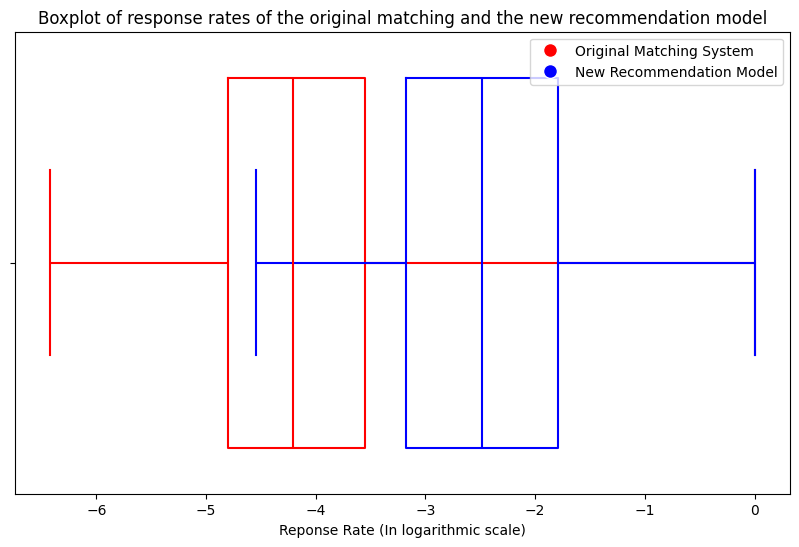

In [29]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df1, x='response_rate', whis=(0, 100), color='r', fill=False)
sns.boxplot(data=df2, x='response_rate', whis=(0, 100), color='b', fill=False)

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Original Matching System'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='New Recommendation Model')]

plt.legend(handles=legend_elements)

plt.xlabel("Reponse Rate (In logarithmic scale)")
plt.title('Boxplot of response rates of the original matching and the new recommendation model')
plt.show()

# Future improvement for the recommendation model